In [1]:
import soundfile as sf
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
from IPython.display import Audio, display

In [2]:
#opening a wav file --- our trusty sitar

audio, samplerate = sf.read('sitar.wav')
buffersize = 156

#we want to zero pad the file so that it will emulate a realtime stream
audio = np.append(audio, np.full(buffersize - (len(audio) % buffersize), 0.0))

print('samplerate = {}'.format(samplerate))
print('audio length = {} seconds'.format(len(audio)/samplerate))
print('array lenght = {} samples'.format(len(audio)))

samplerate = 11025
audio length = 2.462040816326531 seconds
array lenght = 27144 samples


In [3]:
#we can put this in a genorator

def buffer_gen(audio, buffersize):

    index = 0
    while index < len(audio):
        yield(audio[index:index+buffersize])
        index += buffersize
    return

In [8]:
#so now we try with a real time IIR filter

class IIR_realtime():
    
    def __init__(self, b, a):

        #filter coeficiants
        self.A = a
        self.B = b / a[0]
        
        #lengths of coeficiants
        self.M = len(self.B)
        self.Q = len(self.A)
        
        self.clean_last_overlap = np.full(self.M, 0.0)
        self.last_overlap = np.full(self.M, 0.0)
        
    def proccess(self, signal):
        
        #append the last overlap and get the next ---- this is really not so efficiant
        sigLen = len(signal)
        
        signal = np.append(self.clean_last_overlap, signal)
        
        #convolve the signal
        output = np.append(self.last_overlap, np.full(sigLen, 0.0))

        for N in range(self.M, len(signal)):

            output[N] = self.B[0] * signal[N]

            for K in range(1, self.M):

                feedback = (self.A[K] * output[N-K])

                output[N] += (self.B[K] * signal[N - K]) - feedback
                
        self.clean_last_overlap = signal[sigLen:]
        self.last_overlap = output[sigLen:]
        #print(self.last_overlap)
        
        output = output[:sigLen]
        
        return output
        
    def set_coefs(self, b, a):
        #in this implementation can't change the order
        self.A = a
        self.B = b
        
        

[0.01681915 0.0336383  0.01681915]
[ 1.         -1.60109239  0.66836899]


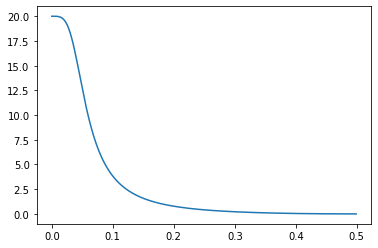

SOS : [[ 0.01681915  0.0336383   0.01681915  1.         -1.60109239  0.66836899]]


In [18]:
#a window that we can test with
order = 2
ripple = .9
cuttoff = 500
#b, a = sig.cheby1(order, ripple, cuttoff, 'low', fs=samplerate)
b, a = sig.butter(order, cuttoff, 'low', fs=samplerate)
print(b)
print(a)
#plot this for show
w, h = sig.freqz(b, a)
plt.plot(w/np.pi/2, 20 * np.abs(h))
plt.show()

SOS = sig.tf2sos(b, a)

print('SOS : {}'.format(SOS))

In [19]:
filt = IIR_realtime(b, a)

buffers = buffer_gen(audio, buffersize)

output = np.empty(0)

for buffer in buffers:
    for coef in SOS:
        filt.set_coefs(coef[:3], coef[3:])
        buffer = filt.proccess(buffer)
        output = np.append(output, buffer)

The Original Audio


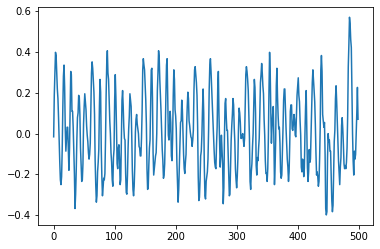

In [20]:
print('The Original Audio')
plt.plot(audio[:500])
plt.show()
display(Audio(audio, rate=samplerate))

The Filtered Audio


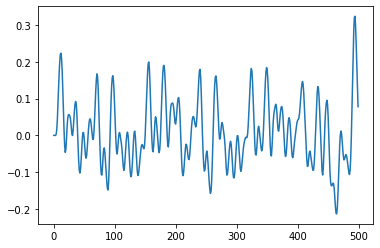

In [21]:
print('The Filtered Audio')
plt.plot(output[:500])
plt.show()
display(Audio(output, rate=samplerate))